In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
from numpy import concatenate
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk9gd_5day.xlsx'
data = pd.read_excel(path, date_parser=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-01-06 00:00:00,154,5,78,175
1,2022-01-06 01:00:00,146,17,77,137
2,2022-01-06 02:00:00,134,7,70,86
3,2022-01-06 03:00:00,146,6,79,69
4,2022-01-06 04:00:00,169,8,73,105


In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M')
#İndex'e Alınması
data.index = data.DATE_TIME

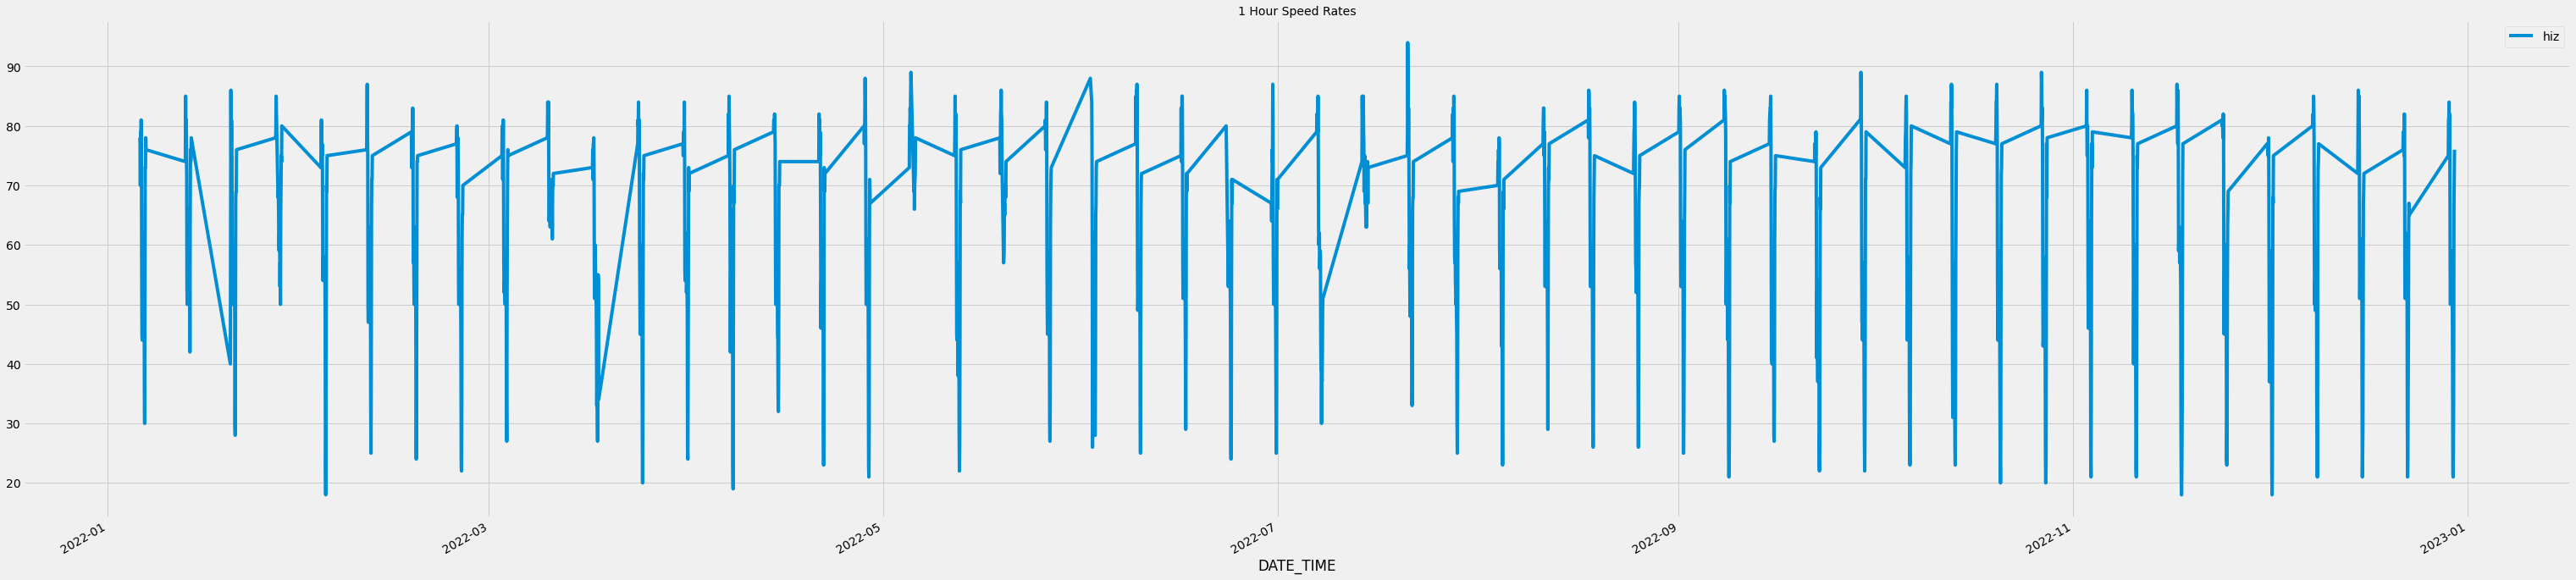

In [4]:
fig = plt.figure(figsize=(48,12))
data.AVERAGE_SPEED.plot(label='hiz')
plt.legend(loc='best')
plt.title('1 Hour Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Örneği Sayıları (training set, test set): " + str((len(train), len(test))))

Veri Örneği Sayıları (training set, test set): (730, 488)


In [26]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        tot = window_size + n_steps_out - 1
        for i in range(int((len(dataset) - tot))):
                start_a = i
                end_a = start_a + window_size
                start_b = end_a
                end_b = end_a + n_steps_out
                a = dataset[start_a:end_a, 0]
                b = dataset[start_b:end_b, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [27]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
train_X, train_Y = create_datasetMultiSteps(train,n_steps_out, window_size)
test_X, test_Y = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(722, 6)


In [10]:
def sigmoid_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev sigmoid
      f = 1 / (1 + np.exp(- 0.25*x)) * (1 - 1 / (1 + np.exp(- 0.25*x)))
   else:  # sigmoid
      f = 1 / (1 + np.exp(- 0.25*x))

   return f


def tanh_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev tanh
      f = 1 - np.square(((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x))))
   else:
      f = ((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x)))

   return f

def Lineer_act(x, der=False):
   import numpy as np

   if (der == True):  # the derivative of the ReLU is the Heaviside Theta
      f = 1
   else:
      f = x

   return f




In [11]:
p = 30  # Gizli Katman 1 neron sayisi
q = 20  # Gizli Katman 2 neron sayisi
r = n_steps_out    # Cikis Katmani neron sayisi

eta = 1 / 100        # Learning rate
alpha = 1 / 300      # Momentum

w10 = np.zeros((p, np.size(train_X, 1)))              # (k-1) 1. Katman Agirlik Degerleri - momentum icin.
w11 = 0.25 * np.random.randn(p, np.size(train_X, 1))  # 1. Katman Agirlik Degerleri
b1 = 0.25 * np.random.randn(p)

w20 = np.zeros((q, p))                          # (k-1) 2. Katman Agirlik Degerleri - momentum icin.
w21 = 0.25 * np.random.randn(q, p)              # 2. Katman Agirlik Degerleri
b2 = 0.25 * np.random.randn(q)

wOut0 = np.zeros((r, q))                        # (k-1) Cikis Katmani Agirlik Degerleri - momentum icin.
wOut1 = 0.25 * np.random.randn(r, q)            # Cikis Katmani Agirlik Degerleri
bOut = 0.25 * np.random.randn(r)

act = tanh_act
act_1 = tanh_act
act_2 = Lineer_act

E_ani_max = []
E_ort = []
epoch = 10000  # Iterasyon Sayisi

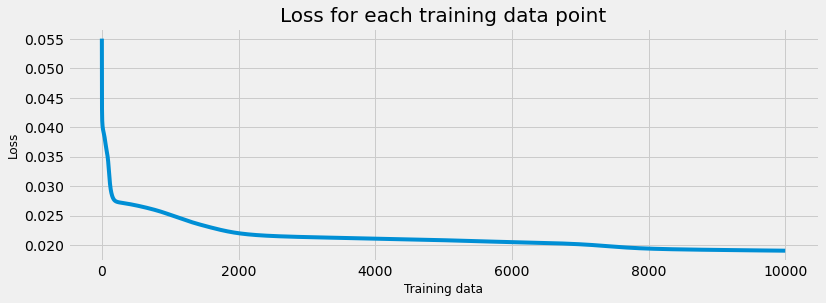

In [12]:
for l in range(epoch):
   E_ani = []
   
   for k in range(np.size(train_X, 0)):
     
      # 1: Egitim Veri Seti Girisi
      
      x = train_X[k]
      
      # 2: Feed forward
      w1 = w11
      v1 = np.dot(w1, x) + b1
      yl1 = act_1(v1)      
      w2 = w21
      v2 = np.dot(w2, yl1) + b2
      yl2 = act_2(v2)  # 2. Katman Cikisi     y2: Gercek cikis olduğundan farklı olsun diye yl2 yazildi.
      
      wOut = wOut1
      v_o = np.dot(wOut, yl2) + bOut
      y = Lineer_act(v_o)  # Cikis Katmani Cikisi
      
      # 2.2: Cikis Katmani Yerel Gradyen
      delta_Out = (train_Y[k] - y) * Lineer_act(v_o, der=True)

      # 2.3: Backpropagate
      delta_2 = np.dot(delta_Out, wOut) * act_2(v2, der=True)  # 2. Katman Yerel Gradyen
      delta_1 = np.dot(delta_2, w2) * act_1(v1, der=True)      # 1. Katman Yerel Gradyen

      # 3: Gradient descent
      wOut = wOut1 + eta * np.outer(delta_Out, yl2) + alpha * (wOut1 - wOut0)  # Cikis Katmani Agirlik güncelleme
      wOut0 = wOut1
      wOut1 = wOut
      bOut = bOut + eta * delta_Out

      w2 = w21 + eta * np.outer(delta_2, yl1) + alpha * (w21 - w20)  # Gizli Katman 2 Agirlik güncelleme
      w20 = w21
      w21 = w2
      b2 = b2 + eta * delta_2

      w1 = w11 + eta * np.outer(delta_1, x) + alpha * (w11 - w10)  # Gizli Katman 1 Agirlik güncelleme
      w10 = w11
      w11 = w1
      b1 = b1 + eta * delta_1

      e = train_Y[k] - y
      
      # 4. loss function Hesaplama

      E_ani.append((1 / 2) * np.dot(e.T, e))

   E_ort.append((1 / np.size(train_X, 0)) * sum(E_ani))
   E_ani_max.append(max(E_ani))

   if l >= 21:
      if abs((E_ort[l - 1]) - (E_ort[l])) <= 0.0000000001 or (E_ort[l - 20]) - (E_ort[l]) <  -0.0005:
         print("E_ort_degisim=",(E_ort[l - 20]) - (E_ort[l]))
         break

      
      # 5. Her Iterasyon icin hatayi cizdiriyoruz

plt.figure(figsize=(12, 4))
#plt.scatter(np.arange(0, l + 1), E_ort, alpha=0.5, s=10, label='Error')
plt.plot(E_ort)
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.legend()
plt.show()


In [13]:
pred_train_Y = []                   # Ag Cikisi Degerleri (k)
E_ani_tr = []
E_ort_tr = []

# 7. Test Veri Seti Girisi


for n in range(np.size(train_X, 0)):
    x_tr = train_X[n]

    v1_tr = np.dot(w1, x_tr) + b1
    y1_tr = act_1(v1_tr)  # 1. Katman Cikisi

    v2_tr = np.dot(w2, y1_tr) + b2
    y2_tr = act_2(v2_tr)  # 2. Katman Cikisi

    v_otr = np.dot(wOut, y2_tr) + bOut
    y_tr = Lineer_act(v_otr)  # Cikis Katmani Cikisi
    e_tr = train_Y[n] - y_tr
    pred_train_Y.append(y_tr)
 

In [14]:

pred_test_Y = []                   # Ag Cikisi Degerleri (k)
E_ani_t = []
E_ort_t = []

# 7. Test Veri Seti Girisi


for m in range(np.size(test_X, 0)):
    x_t = test_X[m]

    v1_t = np.dot(w1, x_t) + b1
    y1_t = act_1(v1_t)  # 1. Katman Cikisi

    v2_t = np.dot(w2, y1_t) + b2
    y2_t = act_2(v2_t)  # 2. Katman Cikisi

    v_ot = np.dot(wOut, y2_t) + bOut
    y_t = Lineer_act(v_ot)  # Cikis Katmani Cikisi
    e_t = test_Y[m] - y_t
    pred_test_Y.append(y_t)


In [15]:
  # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
pred_train_Y = concatenate((train_X[:, -window_size:], pred_train_Y), axis=1)
pred_train_Y = scaler.inverse_transform(pred_train_Y)
pred_train_Y = pred_train_Y[:,-n_steps_out:]

# invert scaling for actual
train_Y = concatenate((train_X[:, -window_size:], train_Y), axis=1)
train_Y = scaler.inverse_transform(train_Y)
train_Y = train_Y[:,-n_steps_out:]

In [16]:
# invert scaling for forecast
pred_test_Y = concatenate(( test_X[:, -window_size:], pred_test_Y), axis=1)
pred_test_Y = scaler.inverse_transform(pred_test_Y)
pred_test_Y = pred_test_Y[:,-n_steps_out:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_Y = concatenate((test_X[:, -window_size:], test_Y), axis=1)
test_Y = scaler.inverse_transform(test_Y)
test_Y = test_Y[:,-n_steps_out:]

In [17]:
score_tr = math.sqrt(mean_squared_error(train_Y, pred_train_Y))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(test_Y, pred_test_Y))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 8.60 RMSE
Test data score: 10.07 RMSE


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_Y, pred_train_Y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_Y, pred_test_Y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_Y[:,0], pred_test_Y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_Y[:,1], pred_test_Y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_Y[:,2], pred_test_Y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)


Train data score: 12.47 MAPE
Test data score: 18.17 MAPE
Test t zamanı score: 13.47 MAPE
Test t+1 zamanı score: 20.07 MAPE
Test t+2 zamanı score: 20.97 MAPE


In [19]:
mdape_tr = np.median((np.abs(np.subtract(train_Y, pred_train_Y)/ train_Y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_Y, pred_test_Y)/ test_Y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 7.01 MdAPE
Test data score: 8.34 MdAPE


In [20]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_Y,pred_train_Y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_Y,pred_test_Y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 34.20 SMAPE
Test data score: 45.31 SMAPE


In [21]:
from sklearn.metrics import mean_absolute_error
e_tr = train_Y - pred_train_Y
scale = mean_absolute_error(train_Y[1:], train_Y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_Y - pred_test_Y
scale = mean_absolute_error(test_Y[1:], test_Y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.93 MASE
Test data score: 1.03 MASE


In [22]:
train_y=train_Y
pred_train_y=pred_train_Y
test_y=test_Y
pred_test_y=pred_test_Y

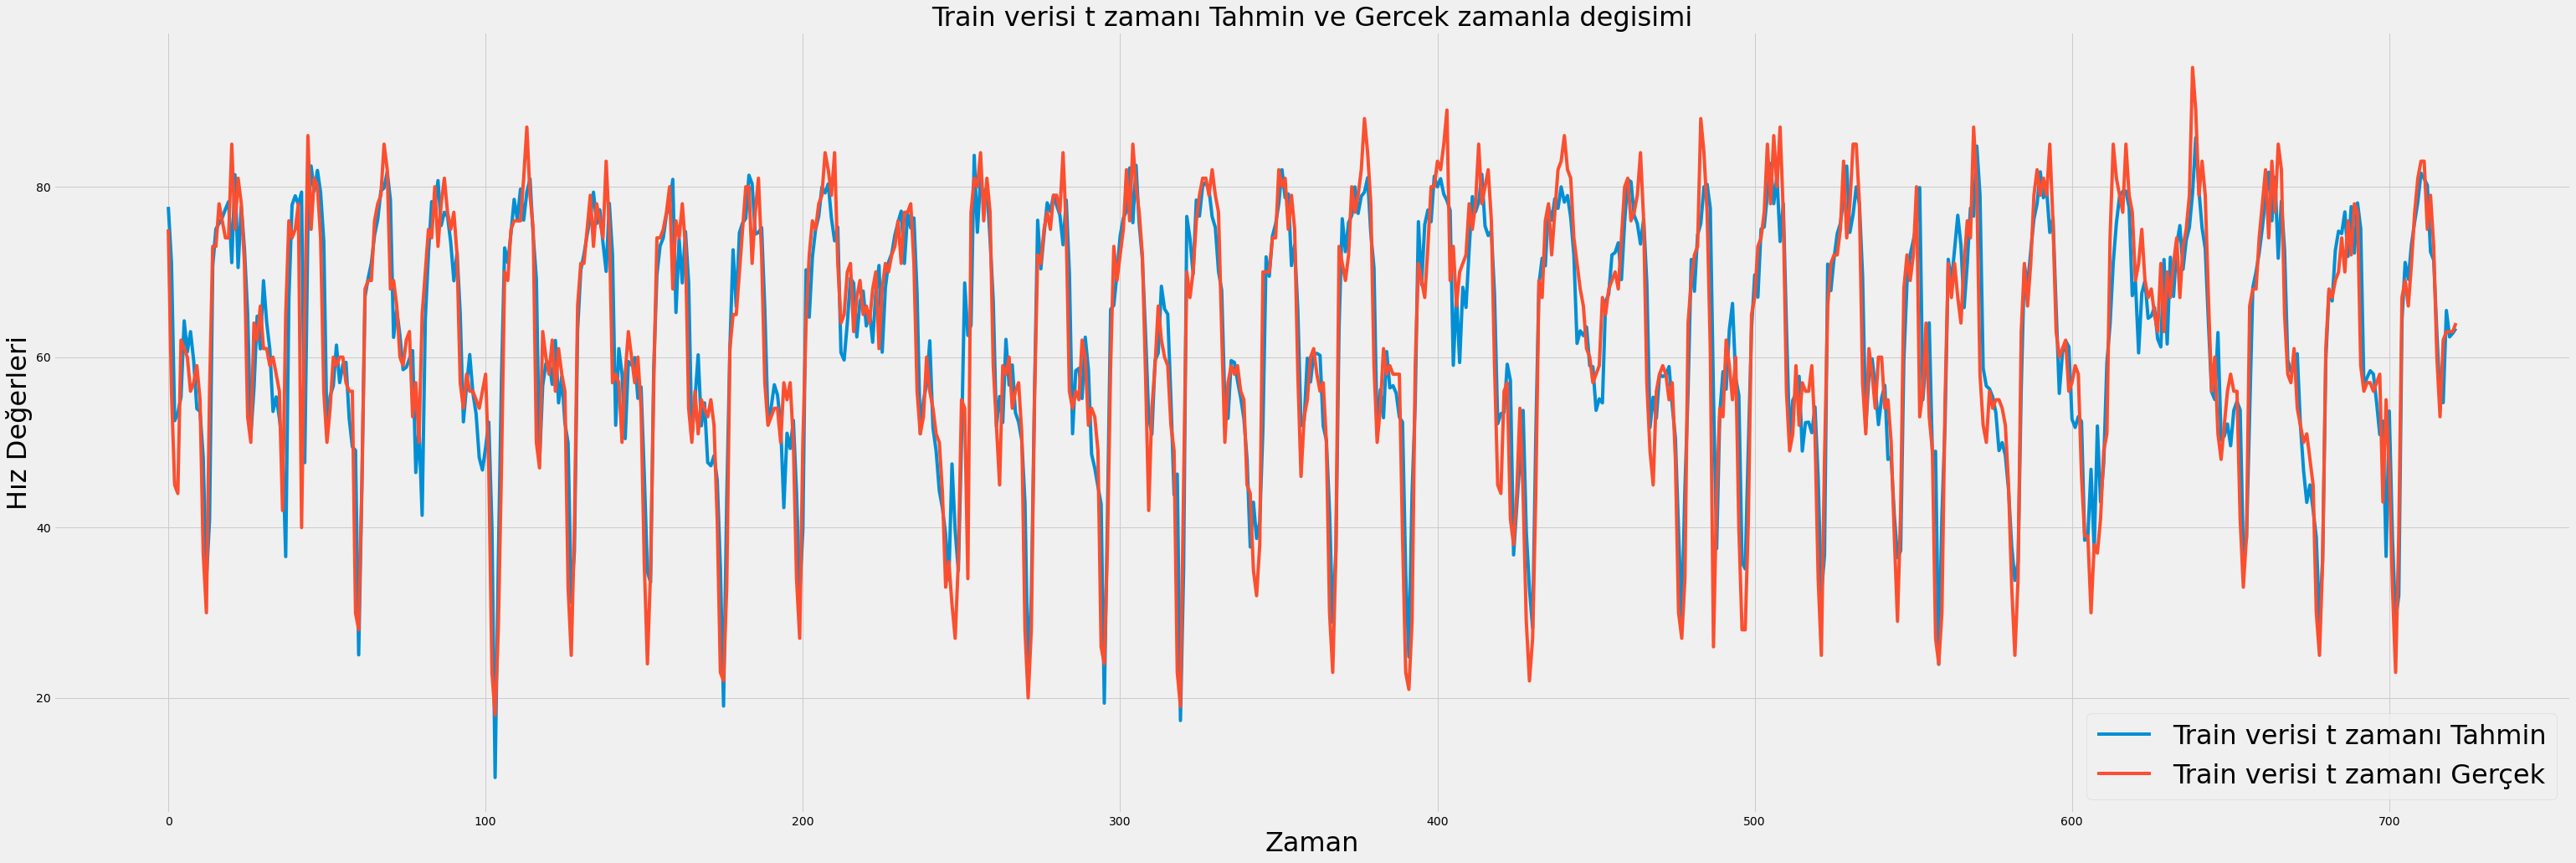

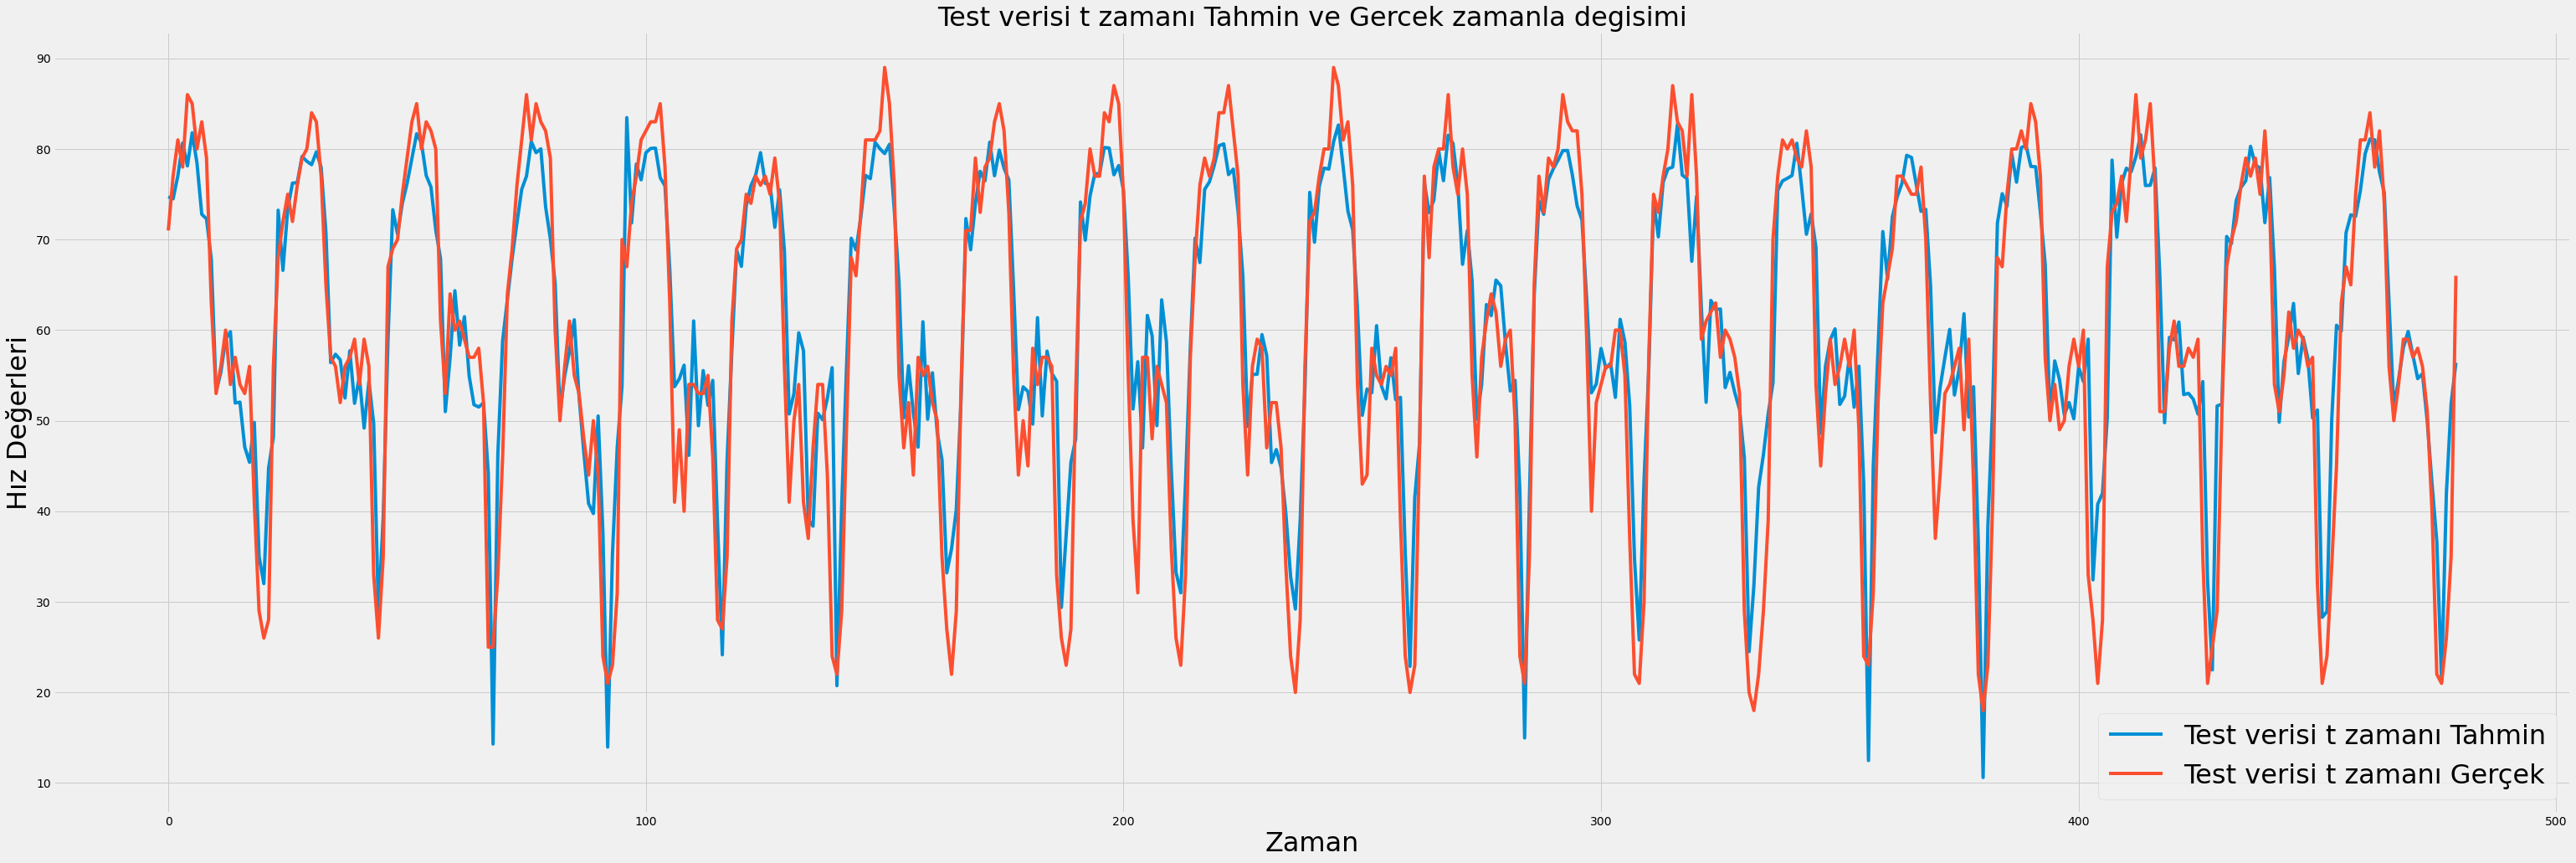

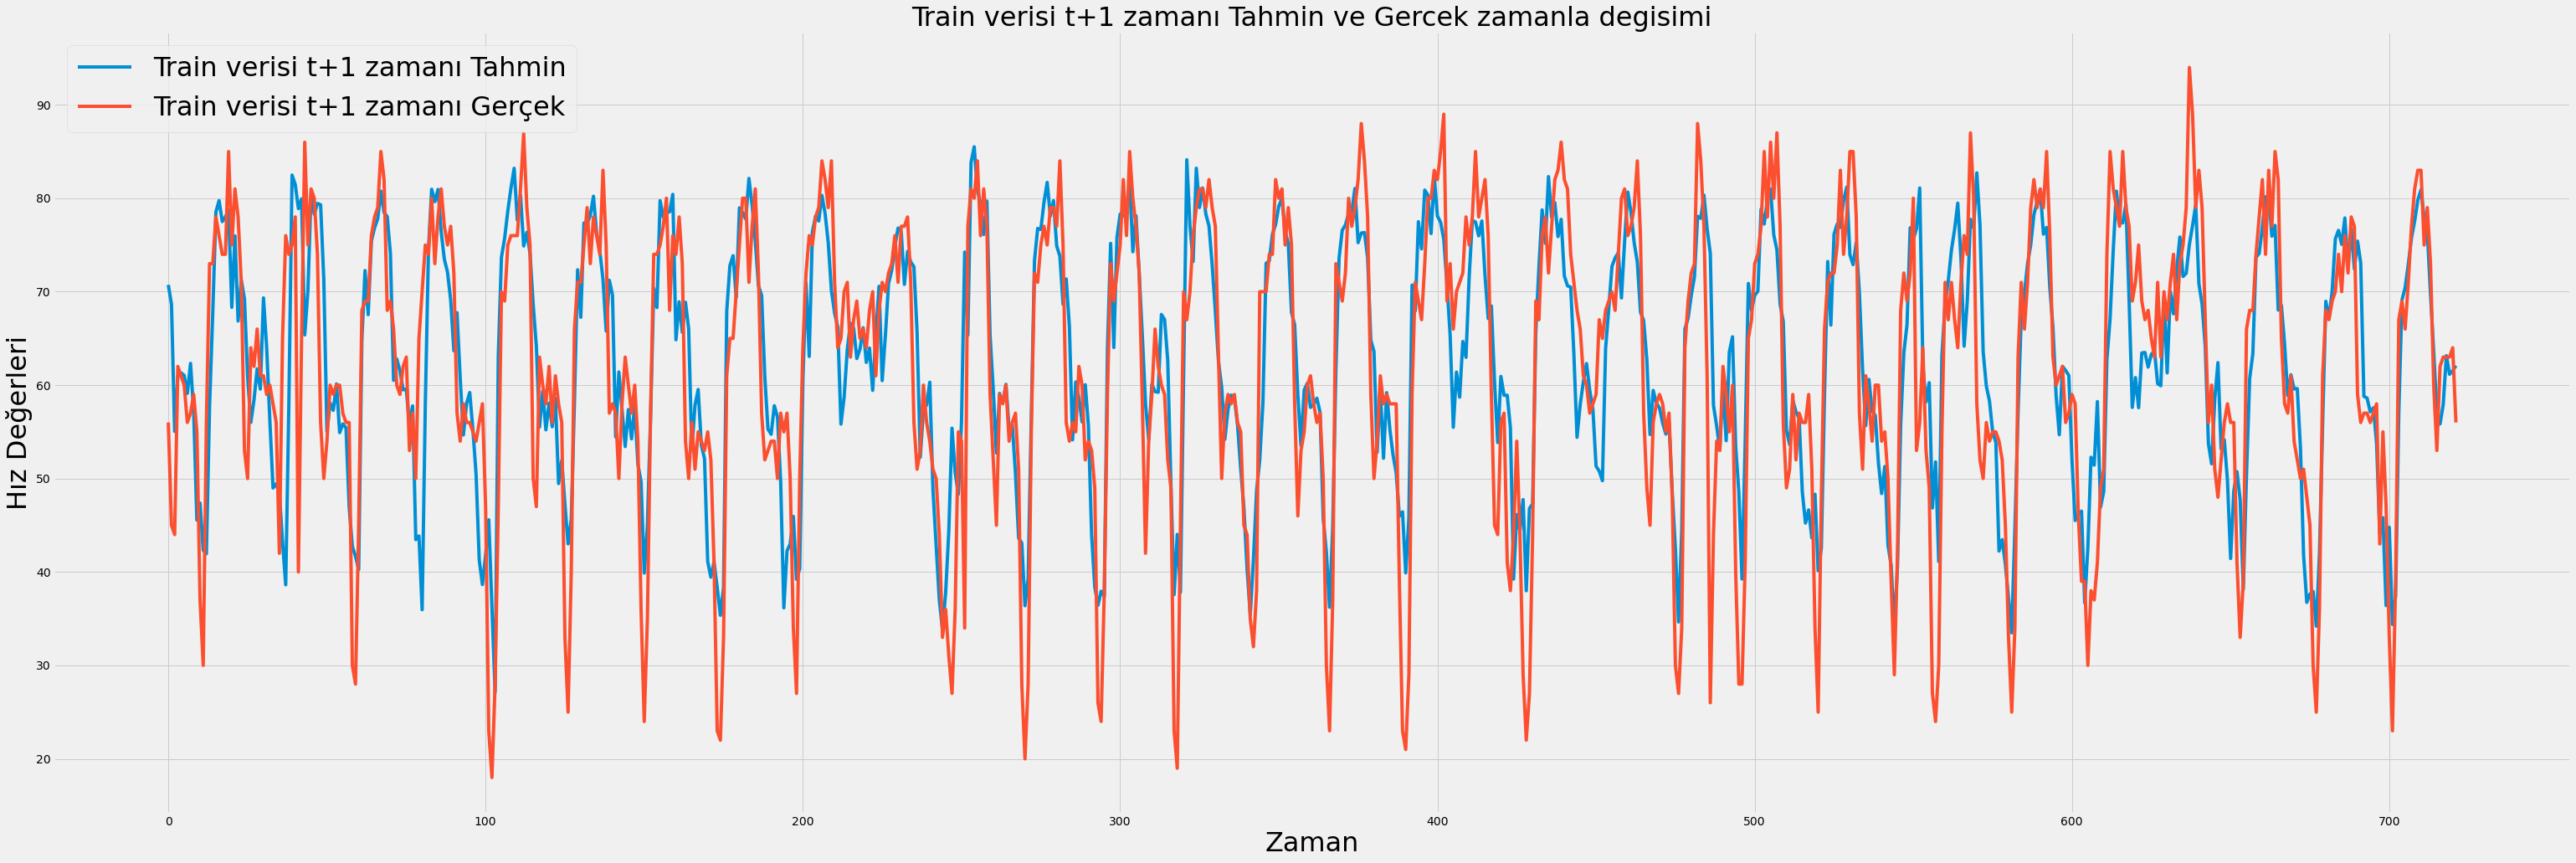

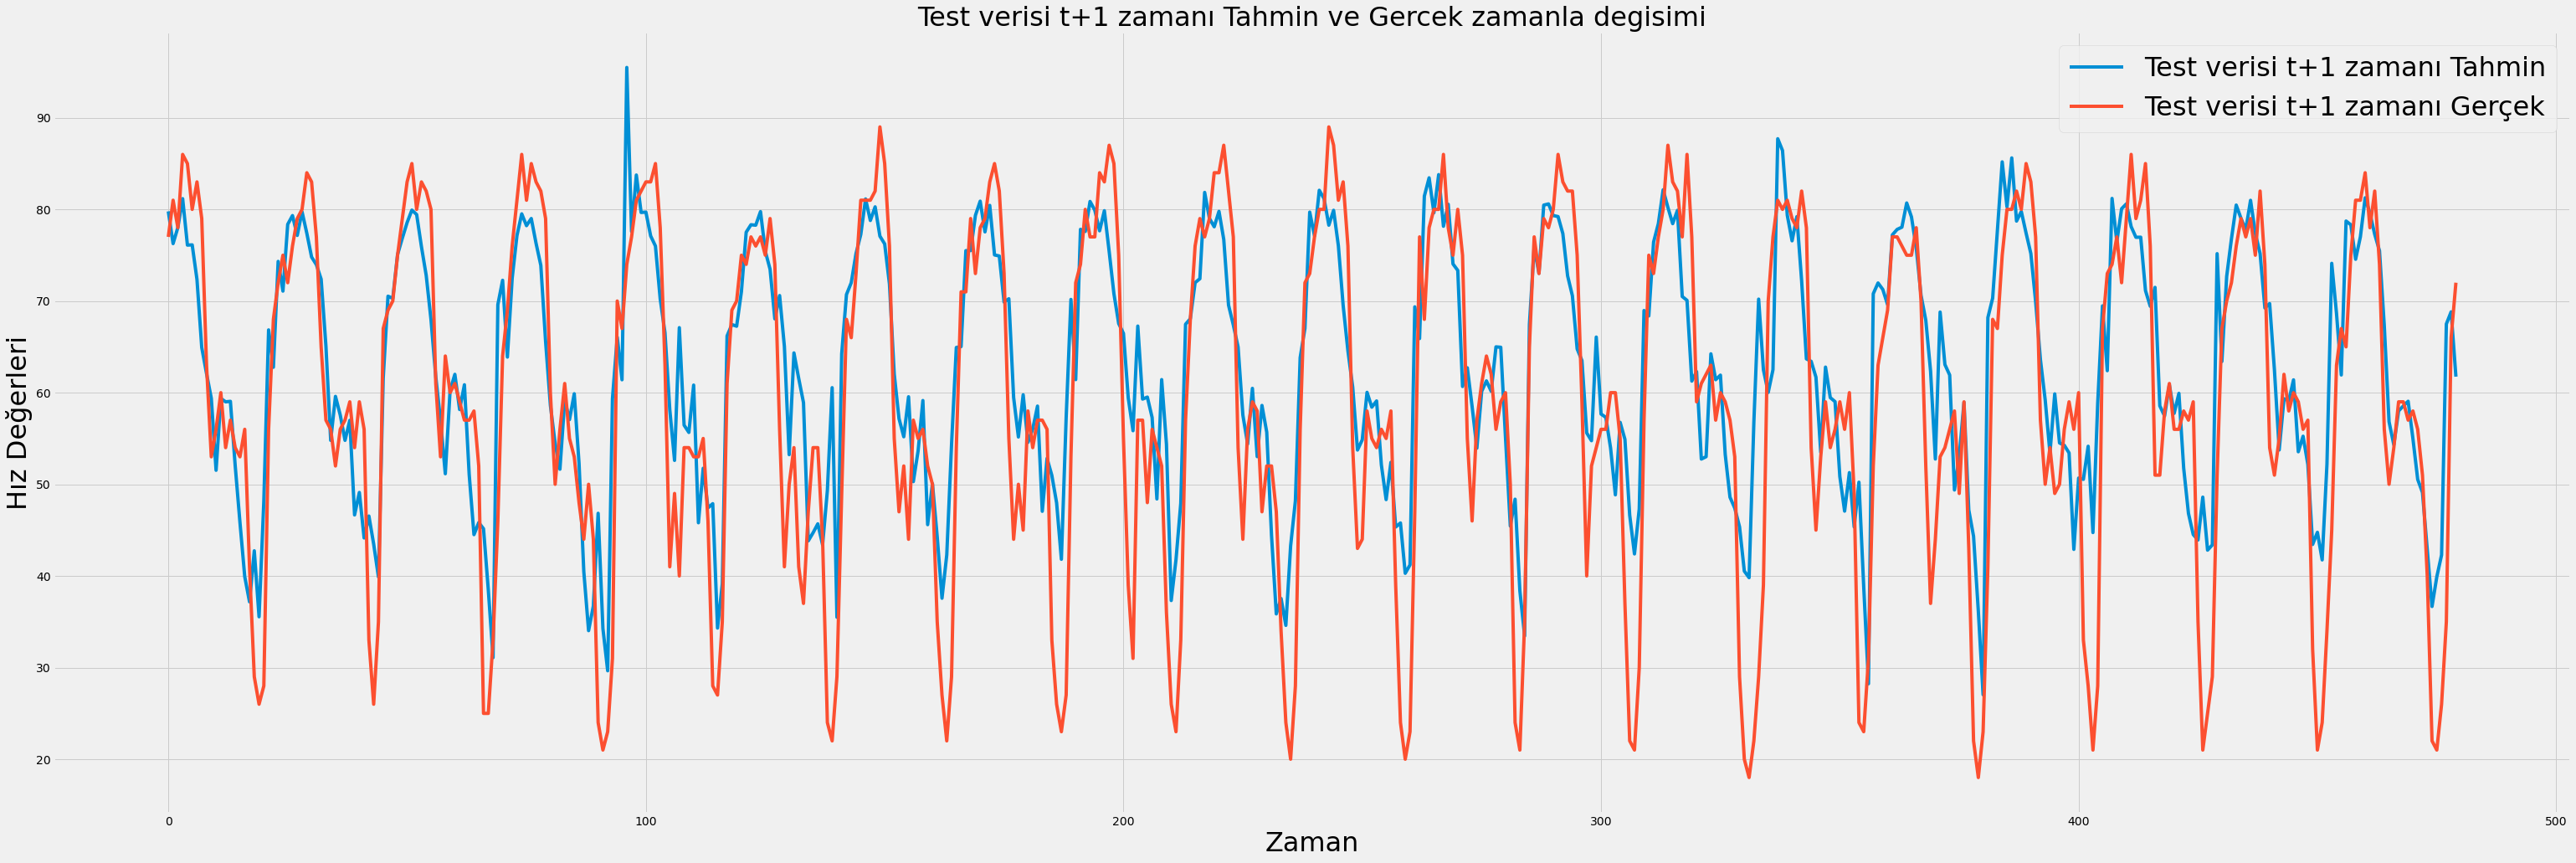

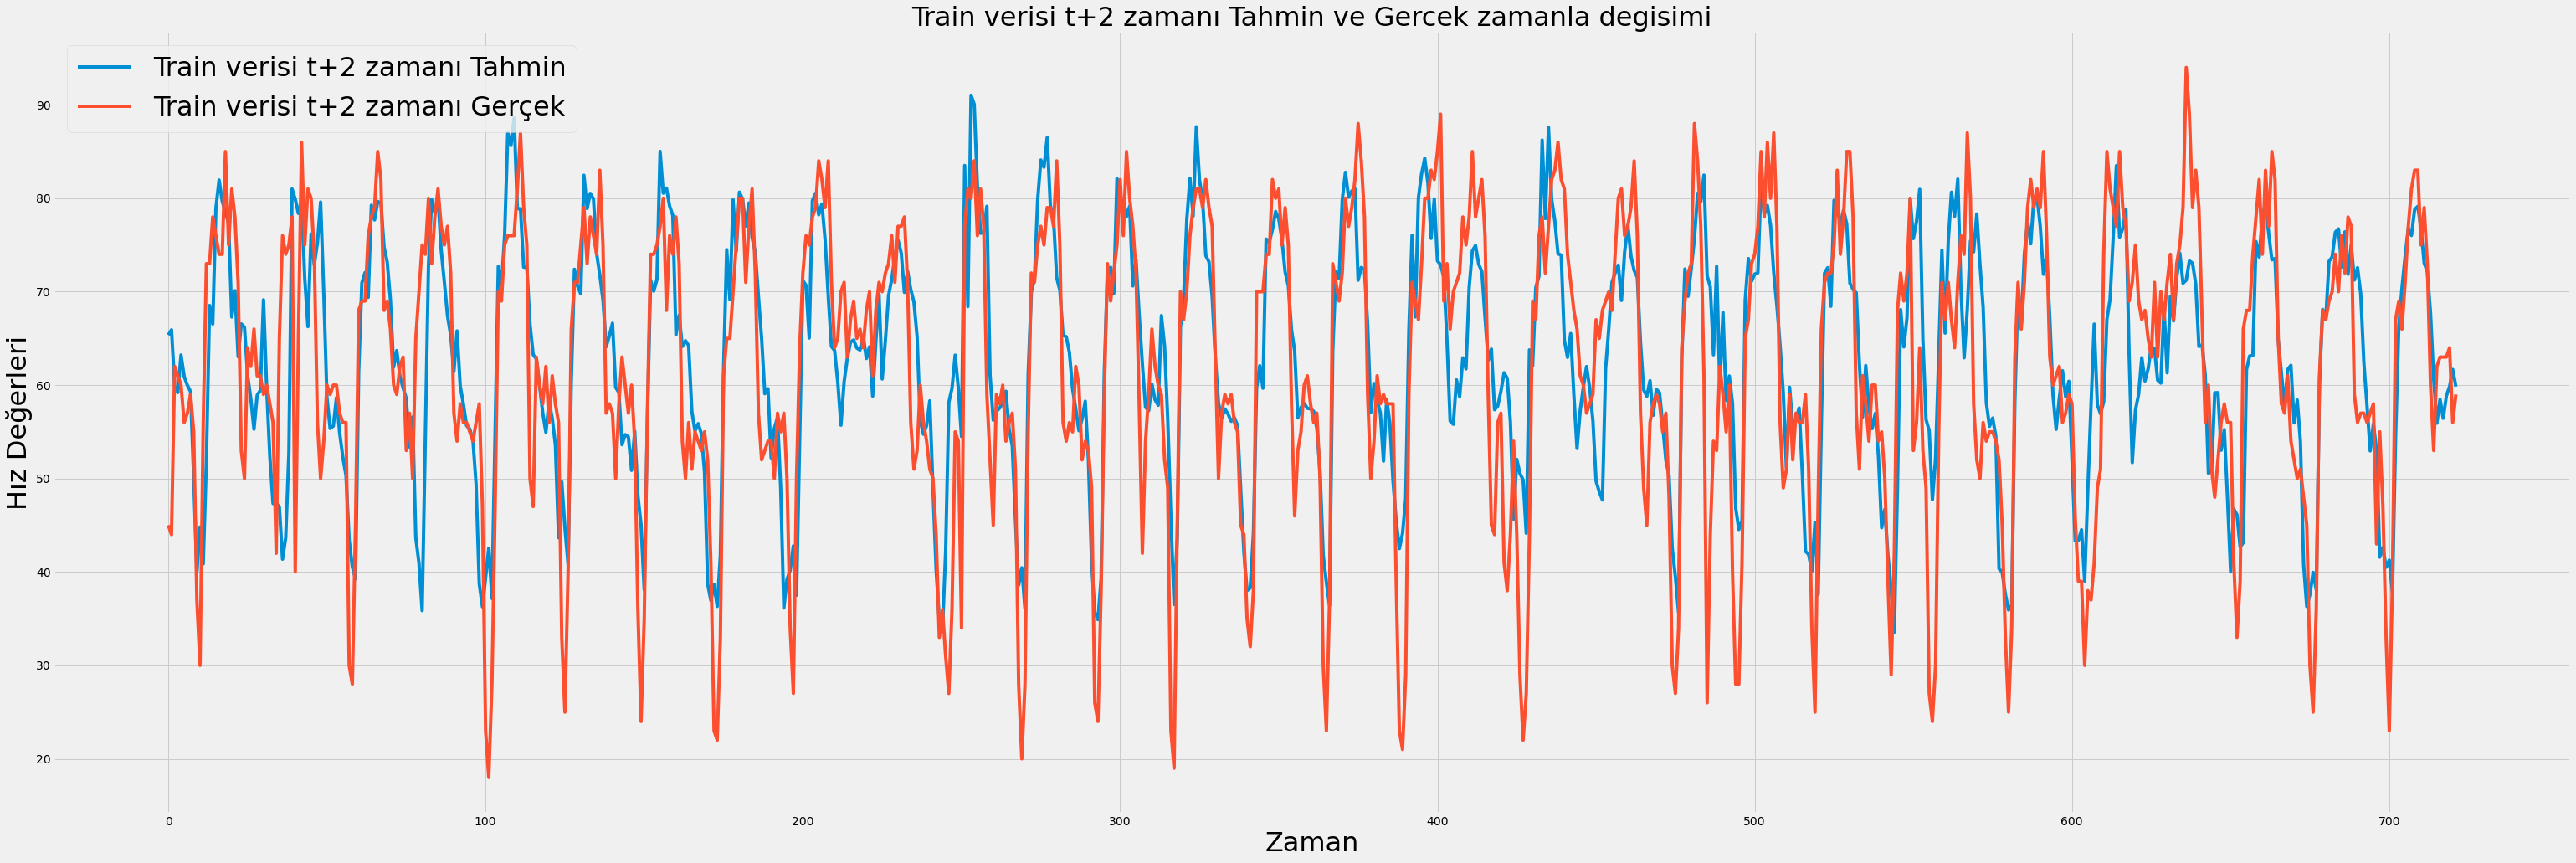

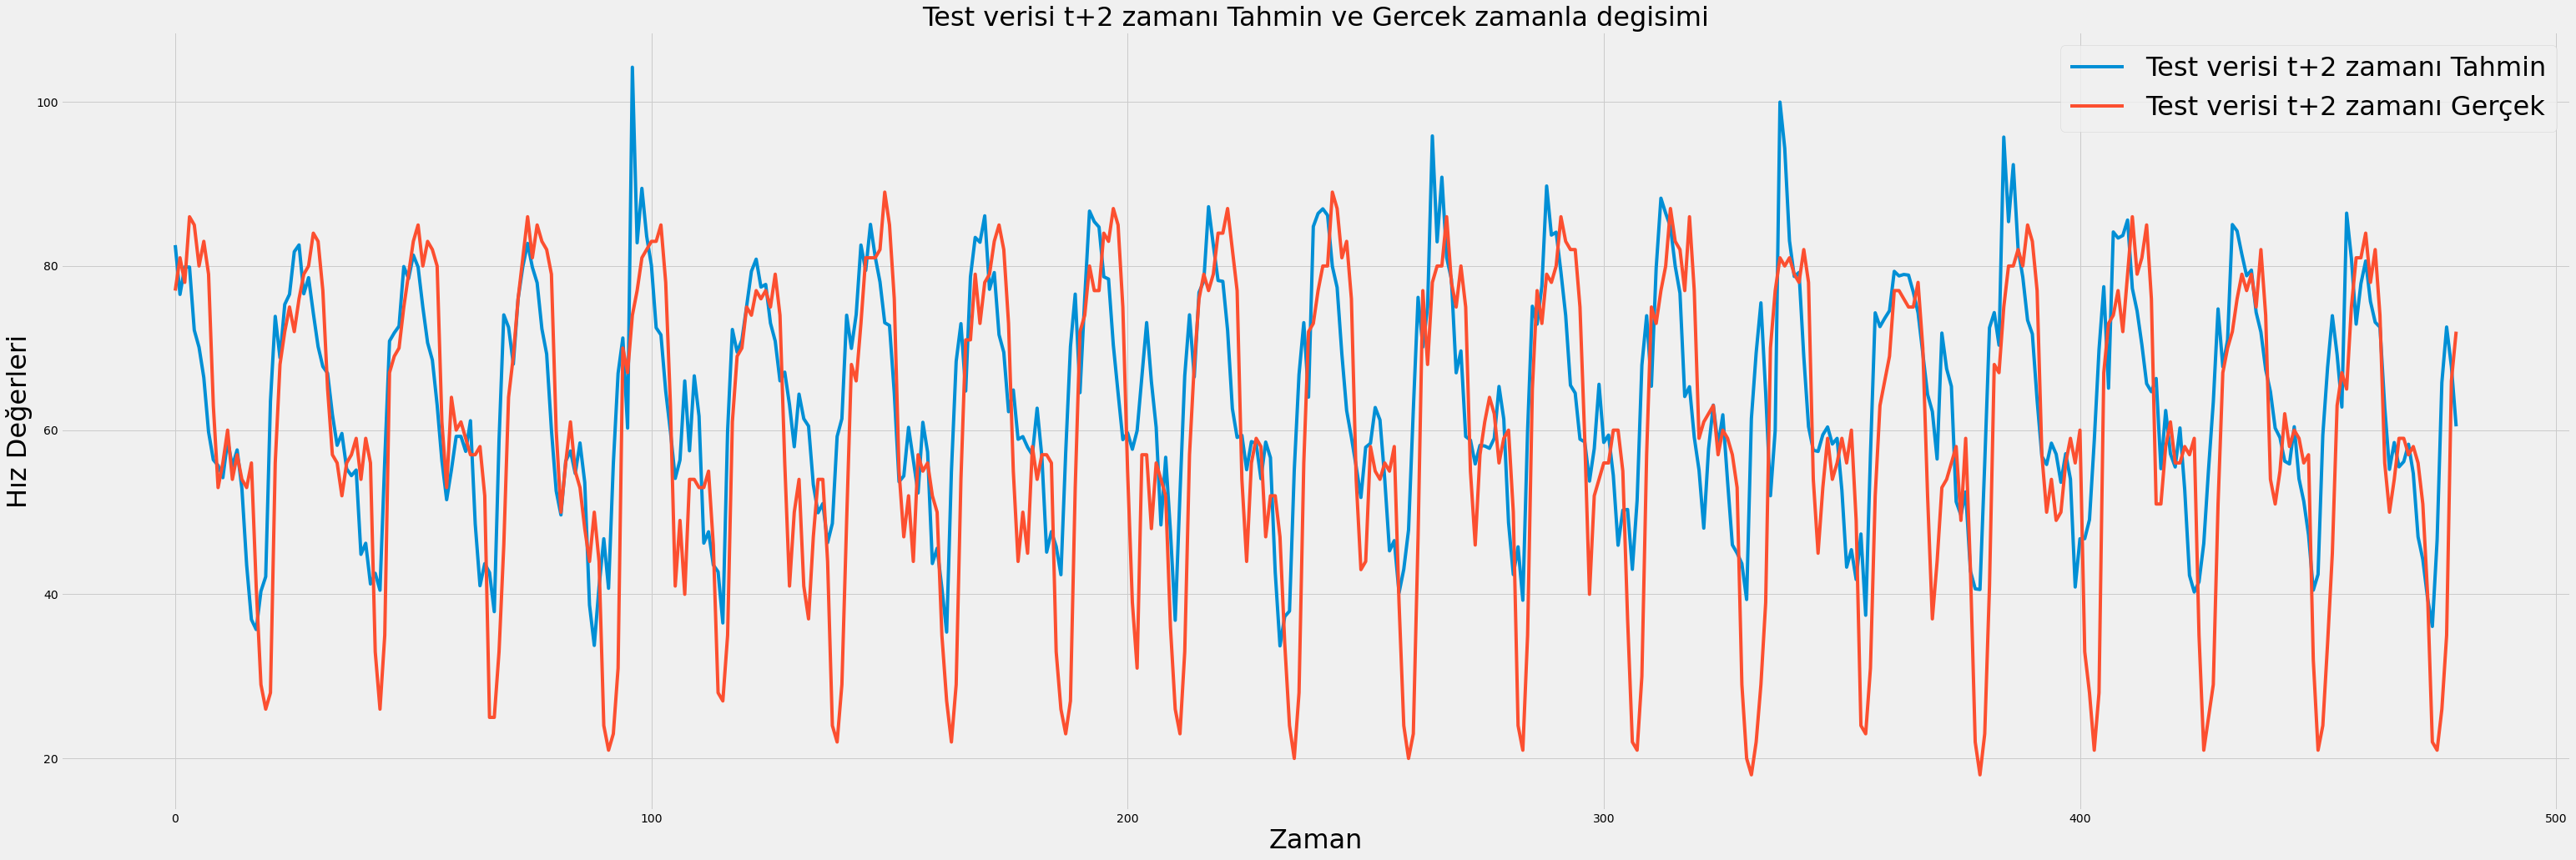

In [23]:
# 10. Test Veri Seti icin Ag sonucu ve verili cikislari cizdiriyoruz

train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y3=test_y[:,2]
pred_test_y2=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

In [24]:
from scipy.stats import f_oneway
f_oneway(train_Y[:, 0], pred_train_Y[:, 0])

F_onewayResult(statistic=0.24992486833051392, pvalue=0.6172042606578827)

In [25]:
f_oneway(test_Y[:, 0], pred_test_Y[:, 0])

F_onewayResult(statistic=1.559868379494799, pvalue=0.21198958708973228)